In [1]:
# 1. Import DataIngestor from your module
from src.ingest import DataIngestor

# 2. Create an instance with your CSV file path
ingestor = DataIngestor("data/sales_data.csv")

# 3. Load and clean the data
df = ingestor.load_and_clean()

# 4. Preview it
df.head()


🔍 Warning: Null values detected in the dataset:
TL SO Alert    11240
dtype: int64
1485 outliers detected in 'total_units'


,Top Level Branch,Top Level Sold To,Zone,Top Level Order,Top Level Line,Last Next Status,Shipment Number(s),TL SO Alert,ECD,ECD Notes,...,Region Zone,delay_days,delay_flag,lead_time,pickup_lead,month,year,week,is_urgent,total_units
0,Branch 1,Customer_5725,West,ORD979385,LINE942260,Delivered,SHP607593,NaN,2021-07-07,on track,...,Zone B,-2,0,11,2,7,2021,27,0,20.008182
1,Branch 2,Customer_1478,East,ORD511328,LINE751062,On Hold,SHP217964,NaN,2025-01-25,demand surge,...,Zone D,17,1,35,2,1,2025,2,0,211.830292
2,Branch 4,Customer_6969,South,ORD601081,LINE281110,On Hold,SHP716060,NaN,2022-05-05,supplier price changes,...,Zone A,14,1,43,2,4,2022,16,0,21.371680
3,Branch 2,Customer_2571,North,ORD235895,LINE853706,Delivered,SHP871471,NaN,2022-01-26,customs backlog,...,Zone C,19,1,28,2,1,2022,1,0,13.026189
4,Branch 4,Customer_9149,North,ORD162338,LINE458078,Shipped,SHP642460,NaN,2024-11-20,on track,...,Zone D,-1,0,27,2,11,2024,47,0,14.608289


In [2]:
# Feature columns
feature_cols = [
    'Zone', 'Region Zone', 'Top Level Branch', 'Top Level Type',
    'SC Rep', 'Line Amount', 'pickup_lead', 'is_urgent',
    'year', 'month'
]

# Define X and y
X = df[feature_cols]
y = df['delay_flag']

# Confirm the shape
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
X.head()


Features shape: (15000, 10)
Target shape: (15000,)


,Zone,Region Zone,Top Level Branch,Top Level Type,SC Rep,Line Amount,pickup_lead,is_urgent,year,month
0,West,Zone B,Branch 1,Type 3,Rep A,6284.57,2,0,2021,7
1,East,Zone D,Branch 2,Type 1,Rep C,5804.15,2,0,2025,1
2,South,Zone A,Branch 4,Type 2,Rep D,7932.74,2,0,2022,4
3,North,Zone C,Branch 2,Type 3,Rep C,6346.75,2,0,2022,1
4,North,Zone D,Branch 4,Type 2,Rep C,6749.76,2,0,2024,11


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Top Level Branch         15000 non-null  object        
 1   Top Level Sold To        15000 non-null  object        
 2   Zone                     15000 non-null  object        
 3   Top Level Order          15000 non-null  object        
 4   Top Level Line           15000 non-null  object        
 5   Last Next Status         15000 non-null  object        
 6   Shipment Number(s)       15000 non-null  object        
 7   TL SO Alert              3760 non-null   object        
 8   ECD                      15000 non-null  datetime64[ns]
 9   ECD Notes                15000 non-null  object        
 10  Line Creation            15000 non-null  datetime64[ns]
 11  Top Level Type           15000 non-null  object        
 12  Schedule Pick Date       15000 n

In [4]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: delay_flag, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

# Split into train and test (80/20) while preserving class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,        # Maintain same delay ratio in train/test
    random_state=42    # For reproducibility
)

# Confirm the shape and class balance
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True))


Train shape: (12000, 10)
Test shape: (3000, 10)

Class distribution in y_train:
delay_flag
1    0.603917
0    0.396083
Name: proportion, dtype: float64

Class distribution in y_test:
delay_flag
1    0.604
0    0.396
Name: proportion, dtype: float64


In [6]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = [
    'Zone',
    'Region Zone',
    'Top Level Branch',
    'Top Level Type',
    'SC Rep',
    'year',
    'month'
]

# 1. Select only categorical columns from training data
X_train_cat = X_train[categorical_cols]

# 2. Create OneHotEncoder instance
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 3. Fit encoder on training categorical data
encoder.fit(X_train_cat)

# 4. Transform training and test categorical data
X_train_encoded = encoder.transform(X_train_cat)
X_test_encoded = encoder.transform(X_test[categorical_cols])

# 5. Check shape and preview
print("Encoded training shape:", X_train_encoded.shape)
print("First 5 encoded rows:\n", X_train_encoded[:5])


Encoded training shape: (12000, 37)
First 5 encoded rows:
 [[0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [7]:
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
encoded_feature_names

array(['Zone_East', 'Zone_North', 'Zone_South', 'Zone_West',
       'Region Zone_Zone A', 'Region Zone_Zone B', 'Region Zone_Zone C',
       'Region Zone_Zone D', 'Top Level Branch_Branch 1',
       'Top Level Branch_Branch 2', 'Top Level Branch_Branch 3',
       'Top Level Branch_Branch 4', 'Top Level Type_Type 1',
       'Top Level Type_Type 2', 'Top Level Type_Type 3', 'SC Rep_Rep A',
       'SC Rep_Rep B', 'SC Rep_Rep C', 'SC Rep_Rep D', 'year_2020',
       'year_2021', 'year_2022', 'year_2023', 'year_2024', 'year_2025',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'], dtype=object)

In [8]:
import pandas as pd

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)


In [9]:
X_train_encoded_df.head()


,Zone_East,Zone_North,Zone_South,Zone_West,Region Zone_Zone A,Region Zone_Zone B,Region Zone_Zone C,Region Zone_Zone D,Top Level Branch_Branch 1,Top Level Branch_Branch 2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
5386,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3958,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13378,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5546,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6439,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
numeric_cols = ['Line Amount', 'pickup_lead', 'is_urgent']


In [11]:
X_train_num = X_train[numeric_cols].reset_index(drop=True)
X_test_num = X_test[numeric_cols].reset_index(drop=True)


In [12]:
X_train_final = pd.concat([X_train_encoded_df.reset_index(drop=True), X_train_num], axis=1)
X_test_final = pd.concat([X_test_encoded_df.reset_index(drop=True), X_test_num], axis=1)


In [13]:
print("Final training shape:", X_train_final.shape)
X_train_final


Final training shape: (12000, 40)


,Zone_East,Zone_North,Zone_South,Zone_West,Region Zone_Zone A,Region Zone_Zone B,Region Zone_Zone C,Region Zone_Zone D,Top Level Branch_Branch 1,Top Level Branch_Branch 2,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Line Amount,pickup_lead,is_urgent
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1135.08,2,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4529.77,2,0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8315.80,2,0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7098.69,2,0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1430.75,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3142.95,2,1
11996,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9284.57,2,1
11997,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4887.61,2,0
11998,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7008.10,2,1


In [14]:
from sklearn.ensemble import RandomForestClassifier

# Create the model
rf_model = RandomForestClassifier(
    n_estimators=100,            # number of trees in the forest
    max_depth=None,              # allow full depth
    class_weight='balanced',     # handle class imbalance
    random_state=42              # for reproducibility
)


In [15]:
rf_model.fit(X_train_final, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [16]:
y_pred = rf_model.predict(X_test_final)
y_proba = rf_model.predict_proba(X_test_final)[:, 1]  # probability of delay (class 1)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.557
Precision: 0.5989348627611635
Recall: 0.8068432671081678
F1 Score: 0.6875146955090524

Confusion Matrix:
 [[ 209  979]
 [ 350 1462]]


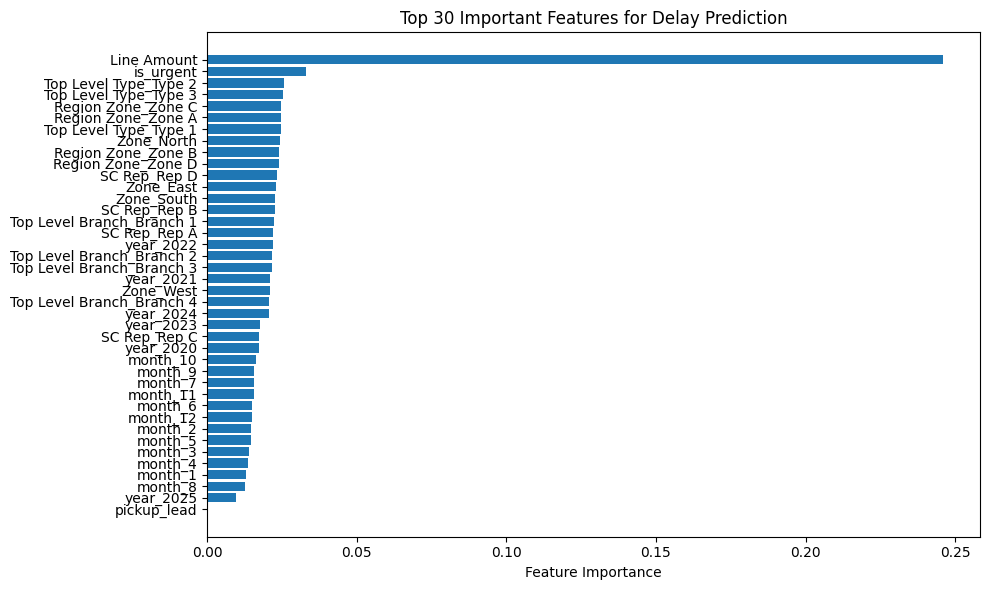

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_final.columns

# Create a DataFrame and sort
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'][:40][::-1], feat_df['Importance'][:40][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 30 Important Features for Delay Prediction")
plt.tight_layout()
plt.show()


In [35]:
threshold = 0.8
y_pred_custom = (y_proba >= threshold).astype(int)
print("Precision:", precision_score(y_test, y_pred_custom))
print("Recall:", recall_score(y_test, y_pred_custom))
print("F1:", f1_score(y_test, y_pred_custom))


Precision: 0.664
Recall: 0.045805739514348784
F1: 0.0856995353639649


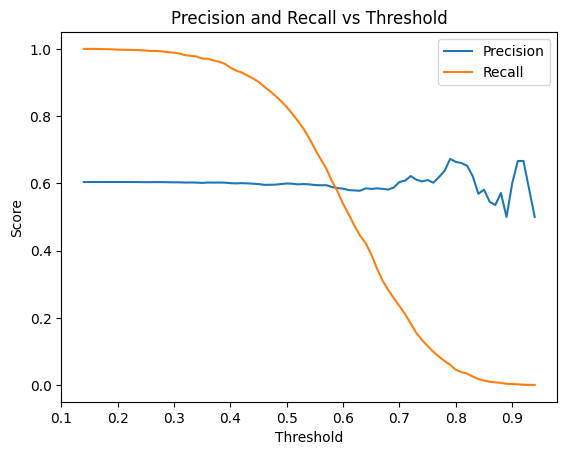

In [36]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.show()


In [37]:
from sklearn.metrics import precision_recall_curve, f1_score

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_index = f1_scores[:-1].argmax()   # Exclude last threshold as PR curve is shorter by 1
best_threshold = thresholds[best_index]

print(f"Best threshold for maximum F1: {best_threshold:.3f}")
print(f"Precision at best threshold: {precisions[best_index]:.3f}")
print(f"Recall at best threshold: {recalls[best_index]:.3f}")
print(f"F1 at best threshold: {f1_scores[best_index]:.3f}")


Best threshold for maximum F1: 0.160
Precision at best threshold: 0.604
Recall at best threshold: 1.000
F1 at best threshold: 0.753


In [38]:
from sklearn.metrics import accuracy_score

threshold = 0.16
y_pred_final = (y_proba >= threshold).astype(int)
acc = accuracy_score(y_test, y_pred_final)
print("Accuracy at threshold 0.16:", acc)


Accuracy at threshold 0.16: 0.6043333333333333


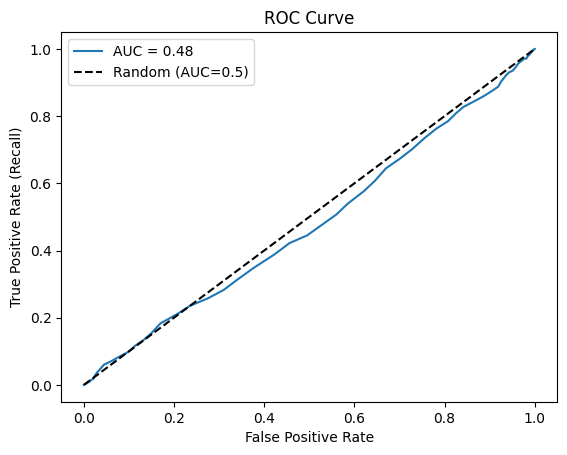

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [43]:
selected_cols = [col for col in X_train_final.columns if col != 'pickup_lead']
rf_model_alt = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model_alt.fit(X_train_final[selected_cols], y_train)
y_proba_alt = rf_model_alt.predict_proba(X_test_final[selected_cols])[:, 1]

from sklearn.metrics import roc_auc_score
print("AUC without Line Amount:", roc_auc_score(y_test, y_proba_alt))


AUC without Line Amount: 0.483004948305721


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the model
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [20]:
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # optimize for F1-score due to class imbalance
    verbose=2,
    n_jobs=-1  # use all processors
)


In [21]:
grid_search.fit(X_train_final, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END ma

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=2)

In [22]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Use the best estimator
best_model = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score: 0.6988790065102688


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_best = best_model.predict(X_test_final)
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       0.37      0.16      0.22      1188
           1       0.60      0.82      0.69      1812

    accuracy                           0.56      3000
   macro avg       0.48      0.49      0.46      3000
weighted avg       0.51      0.56      0.51      3000

[[ 187 1001]
 [ 321 1491]]


In [26]:
from sklearn.linear_model import LogisticRegression


In [27]:
logreg_model = LogisticRegression(
    class_weight='balanced',    # handle 60/40 delay imbalance
    max_iter=1000,              # increase if convergence warning shows
    random_state=42
)


In [28]:
logreg_model.fit(X_train_final, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_logreg = logreg_model.predict(X_test_final)

print("Classification Report:\n", classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))


Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.49      0.43      1188
           1       0.59      0.48      0.53      1812

    accuracy                           0.48      3000
   macro avg       0.49      0.49      0.48      3000
weighted avg       0.51      0.48      0.49      3000

Confusion Matrix:
 [[585 603]
 [942 870]]


In [30]:
from sklearn.neural_network import MLPClassifier


In [31]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # two hidden layers: 64 and 32 neurons
    activation='relu',            # non-linear activation
    solver='adam',                # optimizer
    alpha=0.001,                  # L2 regularization
    learning_rate='adaptive',     # learning rate schedule
    max_iter=300,                 # max number of training iterations
    random_state=42
)


In [32]:
mlp.fit(X_train_final, y_train)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(64, 32),
              learning_rate='adaptive', max_iter=300, random_state=42)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_mlp = mlp.predict(X_test_final)

print("Classification Report:\n", classification_report(y_test, y_pred_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))


Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1188
           1       0.78      0.01      0.02      1812

    accuracy                           0.40      3000
   macro avg       0.59      0.50      0.29      3000
weighted avg       0.63      0.40      0.24      3000

Confusion Matrix:
 [[1183    5]
 [1794   18]]
